# Example of using btrack to track cells in timelapse microscopy data

This notebook covers the following functionality:

* Load segmentation data and localize objects
* Load a table of localized objects 
* Run tracking algorithm
* Inspect the output
* Visualize the results in napari

In addition, we have an extensive tutorial of the cell tracking application as part of *napari*:  

https://napari.org/tutorials/tracking/cell_tracking.html

## Importing btrack and loading example datasets

In [1]:
import btrack

from btrack import datasets

We can automatically download some example data to play with:

In [2]:
CONFIG_FILE = datasets.cell_config()
SEGMENTATION_FILE = datasets.example_segmentation_file()
OBJECTS_FILE = datasets.example_track_objects_file()

## Finding objects to track

### Use case 1 - Objects from segmentation

These could be objects found using algorithms such as a UNet, *CellPose* or *StarDist*. We can use `scikit-image` to load the segmentation data, which returns a numpy array of dimensions (T, Y, X).

In [3]:
import matplotlib.pyplot as plt
from skimage.io import imread

In [4]:
segmentation = imread(SEGMENTATION_FILE)

In [5]:
segmentation.shape

(500, 1200, 1600)

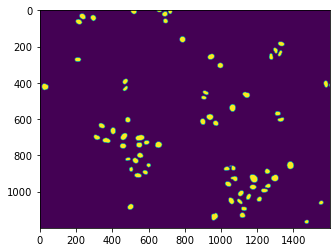

In [6]:
plt.imshow(segmentation[0, ...])

### localize the objects

Now we use a utility function to localise the objects in the segmentation. Note that we can also use scikit-image `regionprops` to calculate properties for each object, using the `properties` keyword:

In [7]:
FEATURES = ["area", "major_axis_length", "minor_axis_length", "orientation"]

objects = btrack.utils.segmentation_to_objects(
    segmentation, 
    properties=tuple(FEATURES), 
)

[INFO][2022/05/17 07:06:25 PM] Localizing objects from segmentation...
[INFO][2022/05/17 07:06:41 PM] Objects are of type: <class 'dict'>
[INFO][2022/05/17 07:06:41 PM] ...Found 52890 objects in 500 frames.


We can also inspect each returned object to determine it's properties:

In [8]:
objects[0]

{'ID': 0, 'x': 517.5736568457539, 'y': 9.072790294627383, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5, 'n_features': 0, 'area': 577, 'major_axis_length': 33.26060270196957, 'minor_axis_length': 22.856213196295688, 'orientation': 1.4557077137732317}

### Use case 2 - from a table of objects

We can also load objects from a simple CSV file, that may contain additional information such as a state label.

In [9]:
# objects = btrack.dataio.import_CSV(OBJECTS_FILE)

In [10]:
# objects[0]

In [11]:
def normalize_properties(obj):
    stats = {k: [] for k in obj[0].properties.keys()}
    for o in obj:
        for k in o.properties.keys():
            if not stats[k]:
                stats[k] = [o.properties[k], o.properties[k]]
            else:
                stats[k] = [min(stats[k][0], o.properties[k]), max(stats[k][1], o.properties[k])]
                
    for o in obj:
        to_update = {}
        for k in o.properties.keys():
            to_update[k] = (o.properties[k] - stats[k][0]) / (stats[k][1] - stats[k][0])
        o.properties = to_update
    return stats

In [12]:
# stats = normalize_properties(objects)

In [13]:
objects[0]

{'ID': 0, 'x': 517.5736568457539, 'y': 9.072790294627383, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5, 'n_features': 0, 'area': 577, 'major_axis_length': 33.26060270196957, 'minor_axis_length': 22.856213196295688, 'orientation': 1.4557077137732317}

In [14]:
# stats

## Running the tracking

In [21]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure_from_file(CONFIG_FILE)
    tracker.verbose = True
    tracker.max_search_radius = 50
    tracker.features = FEATURES

    # append the objects to be tracked
    tracker.append(objects)

    # set the tracking volume
    tracker.volume=((0, 1600), (0, 1200))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=100)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    # get the tracks in a format for napari visualization
    data, properties, graph = tracker.to_napari()
    
    # store the tracks
    tracks = tracker.tracks
    
    # store the configuration
    cfg = tracker.configuration
    
    # export the track data 
#     tracker.export("tracks.h5", obj_type="obj_type_1")
    

[INFO][2022/05/17 07:07:46 pm] Loaded btrack: /Users/arl/Dropbox/Code/py3/BayesianTracker/btrack/libs/libtracker.dylib
[INFO][2022/05/17 07:07:46 pm] btrack (v0.4.3) library imported
[INFO][2022/05/17 07:07:46 pm] Starting BayesianTracker session
[INFO][2022/05/17 07:07:46 pm] Loading configuration file: /Users/arl/Library/Caches/btrack-examples/examples/cell_config.json
[INFO][2022/05/17 07:07:46 pm] Setting max_search_radius -> 50
[INFO][2022/05/17 07:07:46 pm] Setting features -> ['area', 'major_axis_length', 'minor_axis_length', 'orientation']
[INFO][2022/05/17 07:07:46 pm] Objects are of type: <class 'list'>
[INFO][2022/05/17 07:07:47 pm] Setting volume -> ((0, 1600), (0, 1200))
[INFO][2022/05/17 07:07:47 pm] Starting tracking... 
[INFO][2022/05/17 07:07:47 pm] Tracking objects in frames 0 to 99 (of 500)...
[INFO][2022/05/17 07:07:47 pm]  - Timing (Bayesian updates: 0.29ms, Linking: 0.16ms)
[INFO][2022/05/17 07:07:47 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/

GLPK Integer Optimizer, v4.65
1348 rows, 818 columns, 1296 non-zeros
818 integer variables, all of which are binary
Preprocessing...
342 rows, 515 columns, 788 non-zeros
515 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 342
Solving LP relaxation...
GLPK Simplex Optimizer, v4.65
342 rows, 515 columns, 788 non-zeros
*     0: obj =   4.497748386e+04 inf =   0.000e+00 (43)
*    41: obj =   3.691042381e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+    41: mip =     not found yet >=              -inf        (1; 0)
+    41: >>>>>   3.691042381e+04 >=   3.691042381e+04   0.0% (1; 0)
+    41: mip =   3.691042381e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND


## Inspecting the output

We can also inspect each returned track to determine it's properties:

In [16]:
tracks[0]

OrderedDict([('ID', 1), ('t', [0, 1, 2, 3]), ('x', [517.5736568457539, 514.0598290598291, 514.8717948717949, 517.5]), ('y', [9.072790294627383, 5.5584045584045585, 0.7435897435897436, 0.0]), ('z', [0.0, 0.0, 0.0, 0.0]), ('parent', 1), ('root', 1), ('state', [5, 5, 5, 5]), ('generation', 0), ('dummy', [False, False, False, False]), ('area', array([577, 351,  39,   4])), ('major_axis_length', array([33.2606027 , 31.50451336, 17.12167799,  4.47213595])), ('minor_axis_length', array([22.8562132 , 14.84825233,  3.08759104,  0.        ])), ('orientation', array([1.45570771, 1.54419882, 1.55384298, 1.57079633]))])

### Export the configuration

In [17]:
btrack.config.save_config("test_config.json", cfg)

### Reload the saved track data

In [18]:
with btrack.dataio.HDF5FileHandler("tracks.h5", "r", obj_type="obj_type_1") as hdf:
    new_tracks = hdf.tracks
    new_data, new_properties, new_graph = btrack.utils.tracks_to_napari(new_tracks, ndim=2)

[INFO][2022/05/17 07:06:44 PM] Opening HDF file: tracks.h5...
[INFO][2022/05/17 07:06:44 PM] Loading tracks/obj_type_1
[INFO][2022/05/17 07:06:44 PM] Loading objects/obj_type_1 (52581, 5) (52581 filtered: None)
[INFO][2022/05/17 07:06:45 PM] Closing HDF file: tracks.h5


## Visualising the data with napari

Finally, we an inspect the entire tracking output using *napari*:

In [22]:
import napari

viewer = napari.Viewer()

viewer.add_image(
    segmentation, 
    name="Segmentation",
    opacity=0.2,
)

# the track data from the tracker
viewer.add_tracks(
    data, 
    properties=properties, 
    graph=graph, 
    name="Tracks", 
    blending="translucent",
)

# # the track data reconstructed from the exported HDF file
# viewer.add_tracks(
#     new_data, 
#     properties=new_properties, 
#     graph=new_graph, 
#     name="Exported Tracks", 
#     blending="translucent",
# )

<Tracks layer 'Tracks' at 0x17bbb05b0>

In [20]:
cfg

TrackerConfig(name='Default', version='0.4.3', verbose=True, motion_model=MotionModel(measurements=3, states=6, A=array([[1., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]]), H=array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]]), P=array([[ 15.,   0.,   0.,   0.,   0.,   0.],
       [  0.,  15.,   0.,   0.,   0.,   0.],
       [  0.,   0.,  15.,   0.,   0.,   0.],
       [  0.,   0.,   0., 150.,   0.,   0.],
       [  0.,   0.,   0.,   0., 150.,   0.],
       [  0.,   0.,   0.,   0.,   0., 150.]]), R=array([[5., 0., 0.],
       [0., 5., 0.],
       [0., 0., 5.]]), G=array([[ 7.5,  7.5,  7.5, 15. , 15. , 15. ]]), Q=array([[ 56.25,  56.25,  56.25, 112.5 , 112.5 , 112.5 ],
       [ 56.25,  56.25,  56.25, 112.5 , 112.5 , 112.5 ],
       [ 56.25,  56.25,  56.25, 112.5 , 112.5 , 112.5 ],
       [112.5 , 112.